    Time series analysis attempts to understand the past and predict the future of Netflix stock prices

In [1]:
#STOCK - NETFLIX
import pandas as pd

#extract Netflix stock prices data from various Internet sources into a pandas DataFrame
import pandas_datareader as web
import datetime
start = datetime.datetime(2014, 12, 1)
end = datetime.datetime(2019, 11, 1)
#Reading upto 5 years of Netflix stocks from Yahoo Finance
nflx = web.DataReader('NFLX', 'yahoo', start, end)
#Displaying top 10 rows
nflx.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-01,49.571430,48.234287,49.285713,48.830002,11964400.0,48.830002
2014-12-02,50.477142,48.691429,48.757141,50.330002,14271600.0,50.330002
2014-12-03,50.731430,49.181427,50.221428,50.731430,13819400.0,50.731430
2014-12-04,51.135715,49.908573,50.428570,50.085712,11853800.0,50.085712
2014-12-05,50.642857,49.732857,50.147144,50.131428,9930200.0,50.131428
2014-12-08,49.982857,48.290001,49.881428,48.497143,13621300.0,48.497143
2014-12-09,49.337143,47.002857,47.820000,49.111427,17976700.0,49.111427
2014-12-10,49.247143,47.665714,49.021427,47.759998,12644800.0,47.759998
2014-12-11,48.700001,47.655716,48.012856,47.804287,11769100.0,47.804287


In [2]:
#Converts the stock prices stored in the variable 'nflx' into a CSV file on the system
nflx.to_csv('nflx.csv') 

In [3]:
#Reading data again from CSV (with index)
import pandas as pd
nflx = pd.read_csv('nflx.csv')

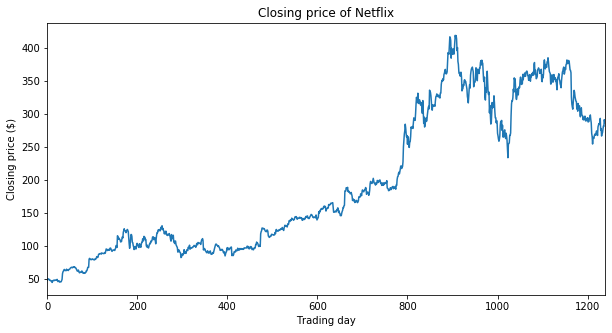

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
#Plotting the closing prices
plt.figure(figsize=(10, 5))
plt.title('Closing price of Netflix')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
close = nflx['Close']
close.plot()

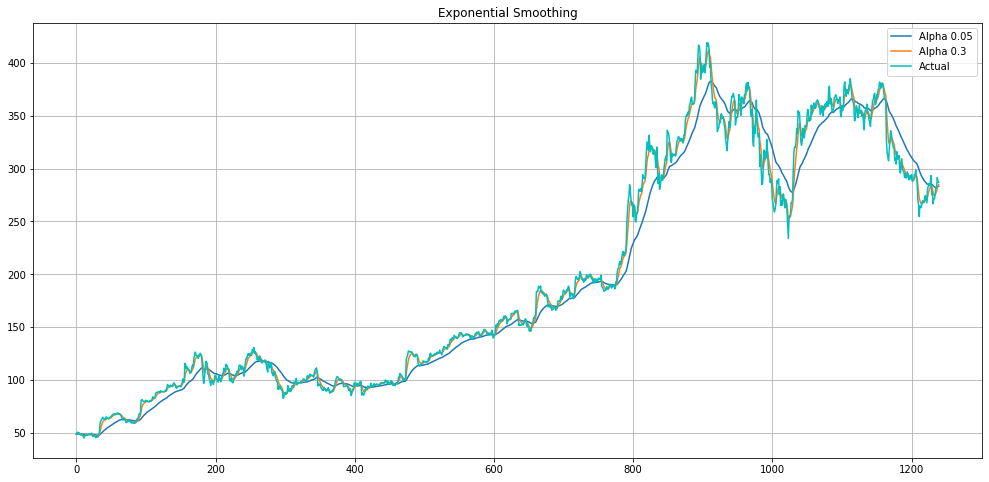

In [5]:
#Single Exponential Smoothing 
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

    #Plotting exponential smoothing
plot_exponential_smoothing(nflx.Close, [0.05, 0.3])

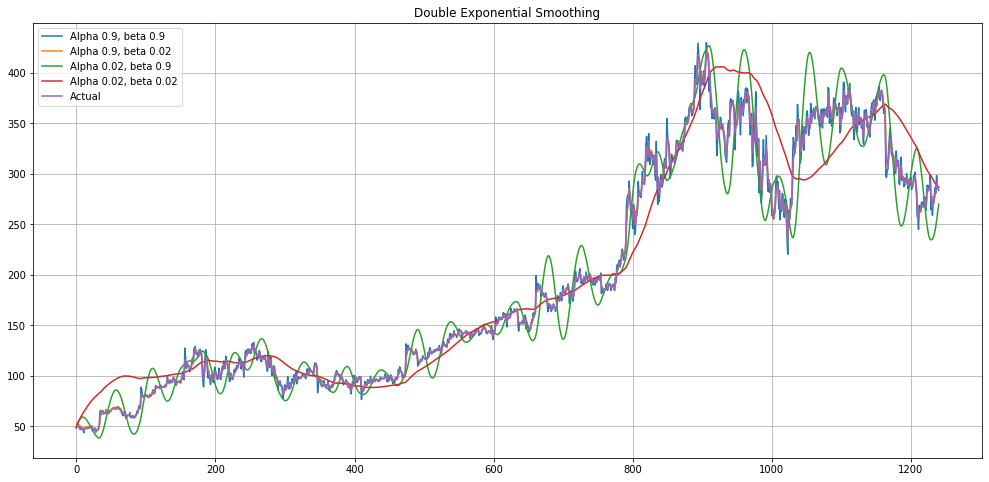

In [6]:
#Double Exponential Smoothing
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

#Plotting the graph
def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(nflx.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

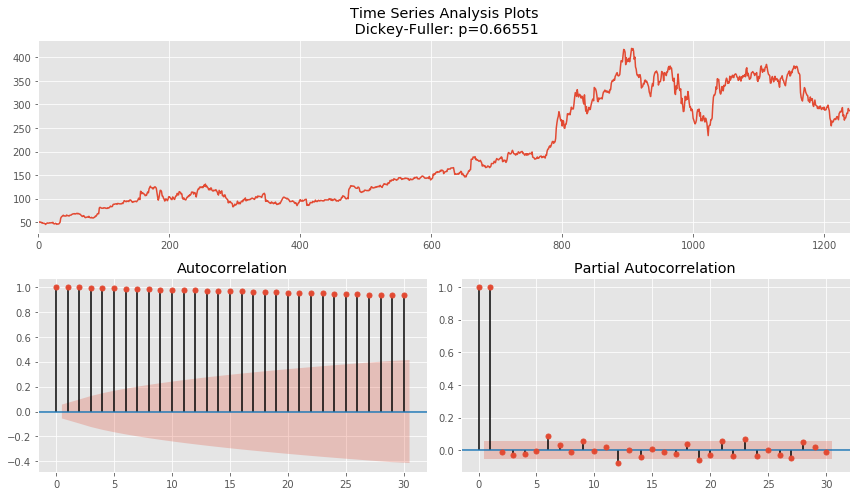

In [7]:
#Provides functions for statistical models and data exploration
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='ggplot'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='ggplot'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(nflx.Close, lags=30)

In [8]:
#Time Series in not stationary and there is no evident seasonal behaviour and the autocorrelation is too high.

In [9]:
# Data transformations - Replacing spaces with _
nflx.columns = [x.strip() for x in nflx.columns]
nflx.columns = [x.replace(' ', '_') for x in nflx.columns]

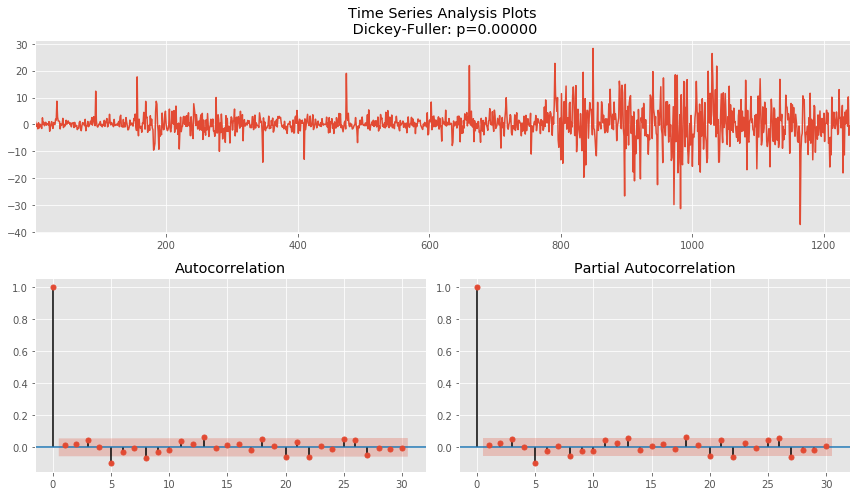

In [10]:
#Taking First difference to make the process stationary - We can decrease the autocorrelation and make the time series more 
#stationary by taking a difference of the time series by itself with a lag of 1 day
data_diff = nflx.Close - nflx.Close.shift(1)

tsplot(data_diff[1:], lags=30)

In [11]:
#RandomForestRegressor with scikit learn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [12]:
#Displaying first 20 records with processed data
nflx.head(20)

,Date,High,Low,Open,Close,Volume,Adj_Close
0,2014-12-01,49.571430,48.234287,49.285713,48.830002,11964400.0,48.830002
1,2014-12-02,50.477142,48.691429,48.757141,50.330002,14271600.0,50.330002
2,2014-12-03,50.731430,49.181427,50.221428,50.731430,13819400.0,50.731430
3,2014-12-04,51.135715,49.908573,50.428570,50.085712,11853800.0,50.085712
4,2014-12-05,50.642857,49.732857,50.147144,50.131428,9930200.0,50.131428
5,2014-12-08,49.982857,48.290001,49.881428,48.497143,13621300.0,48.497143
6,2014-12-09,49.337143,47.002857,47.820000,49.111427,17976700.0,49.111427
7,2014-12-10,49.247143,47.665714,49.021427,47.759998,12644800.0,47.759998
8,2014-12-11,48.700001,47.655716,48.012856,47.804287,11769100.0,47.804287
9,2014-12-12,48.322857,46.980000,47.417141,47.782856,13521200.0,47.782856


In [13]:
 # Shift Closing price down by 700 days to predict next day
pd.concat([nflx.Close, nflx.Close.shift(-700)], axis=1)

,Close,Close
0,48.830002,185.149994
1,50.330002,183.639999
2,50.731430,182.630005
3,50.085712,182.350006
4,50.131428,184.619995
...,...,...
1235,281.859985,NaN
1236,281.209991,NaN
1237,291.450012,NaN
1238,287.410004,NaN


In [14]:
#Removing the NA values from all the cells 
#Removing the timestamp from the training data as it is not relevant to the model
#Removing an unwanted column like 'Adj Close'
#Creating a training model to predict Closing price (y - dependent variable) with the help 
#of other columns (X - independent variables)
def valid(col):
    return 'Close' not in col and 'Date' not in col and col != 'Adj_Close_'
nflx = nflx.dropna()
X = nflx[[x for x in nflx.columns if valid(x)]].iloc[:-700]
y = nflx.Close.shift(-700).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [15]:
X.T

,0,1,2,3,4,5,6,7,8,9,...,530,531,532,533,534,535,536,537,538,539
High,4.957143e+01,5.047714e+01,5.073143e+01,5.113572e+01,5.064286e+01,4.998286e+01,4.933714e+01,4.924714e+01,4.870000e+01,4.832286e+01,...,1.319900e+02,1.322200e+02,1.315000e+02,1.308500e+02,1.339300e+02,1.354000e+02,1.336500e+02,1.434600e+02,1.407900e+02,1.394900e+02
Low,4.823429e+01,4.869143e+01,4.918143e+01,4.990857e+01,4.973286e+01,4.829000e+01,4.700286e+01,4.766571e+01,4.765572e+01,4.698000e+01,...,1.298900e+02,1.292900e+02,1.292500e+02,1.285000e+02,1.305800e+02,1.320900e+02,1.310600e+02,1.382500e+02,1.376600e+02,1.373100e+02
Open,4.928571e+01,4.875714e+01,5.022143e+01,5.042857e+01,5.014714e+01,4.988143e+01,4.782000e+01,4.902143e+01,4.801286e+01,4.741714e+01,...,1.314800e+02,1.312700e+02,1.309100e+02,1.306300e+02,1.311500e+02,1.350400e+02,1.332100e+02,1.420100e+02,1.393600e+02,1.386500e+02
Volume,1.196440e+07,1.427160e+07,1.381940e+07,1.185380e+07,9.930200e+06,1.362130e+07,1.797670e+07,1.264480e+07,1.176910e+07,1.352120e+07,...,5.771800e+06,5.985800e+06,5.615100e+06,5.388900e+06,1.051500e+07,1.222020e+07,1.616860e+07,2.320340e+07,9.497400e+06,7.433900e+06


In [16]:
# Create a model 
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

C:\Users\keert\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [17]:
#We can go upto 700 days in the past in order to maintain an accuracy of 70% or more
rf_model.score(X_test, y_test)

0.7915298838510686